In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(directory=DATA_DIR, ext=ext, setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|████████████████████████████████████████████████████| 27330/27330 [00:03<00:00, 8218.65it/s]


In [4]:
insects = ['v', 'wmv', 'c', 'sw', 't', 'bl', 'm', 'k', 'wrl', 'sp', 'wswl', 'v(cy)']
dfs.df = dfs.df[dfs.df.label.isin(insects)]
dfs.df = dfs.df[~dfs.df['label'].isin(['st','vuil'])]
dfs.df.label = dfs.df.label.apply(lambda x: 'v' if x=='v(cy)' else x)
dfs.df.reset_index(drop=True, inplace=True)
dfs.df.label.value_counts()

v       5377
wmv     4712
c       4575
sw      2445
t       2390
bl      2318
m       1552
k       1087
wrl     1017
sp       611
wswl     571
Name: label, dtype: int64

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.16it/s]


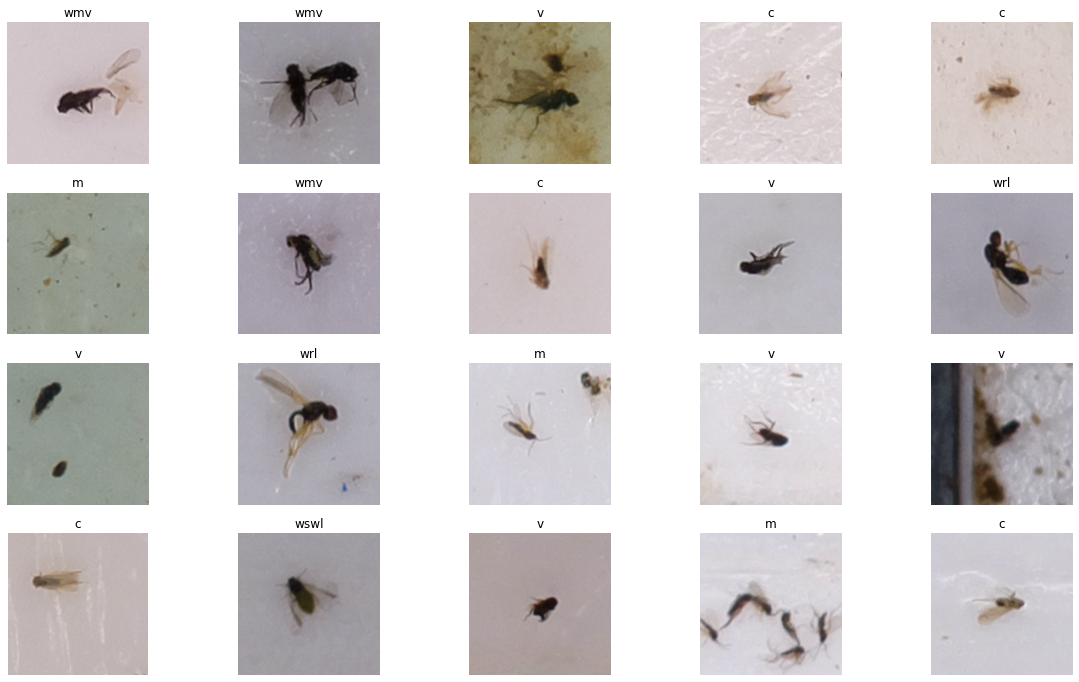

In [5]:
dfs.plot_samples()

# Extra feature collection

In [6]:
batch_size=32
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
l_blur_factors = [0]*len(dfs)
l_meansRGB = [0]*len(dfs)
l_stdsRGB = [0]*len(dfs)
l_nb_contours, l_mean_cnt_area, l_mean_cnt_perimeter, l_std_cnt_area, l_std_cnt_perimeter = [0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs)

c=0
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for i,f in enumerate(filename):
        l_blur_factors[c] = calc_variance_of_laplacian(f)
        meanRGB, stdRGB = calc_mean_RGB_vals(f)
        l_meansRGB[c] = meanRGB
        l_stdsRGB[c] = stdRGB
        nb_contours, mean_cnt_area, mean_cnt_perimeter, std_cnt_area, std_cnt_perimeter = calc_contour_features(f)
        l_nb_contours[c] = nb_contours
        l_mean_cnt_area[c] = mean_cnt_area
        l_mean_cnt_perimeter[c] = mean_cnt_perimeter
        l_std_cnt_area[c] = std_cnt_area
        l_std_cnt_perimeter[c] = std_cnt_perimeter
        c+=1

  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
df_rgb = pd.DataFrame(l_meansRGB, columns=['R','G','B'])
df_feats = pd.DataFrame({'blur': l_blur_factors, 
                        'nb_contours': l_nb_contours,
                        'mean_cnt_area': l_mean_cnt_area,
                        'mean_cnt_perimeter': l_mean_cnt_perimeter,
                        'std_cnt_area': l_std_cnt_area,
                        'std_cnt_perimeter': l_std_cnt_perimeter})
df_feats = pd.concat([df_feats, df_rgb], axis=1)
feature_columns = df_feats.columns


df = pd.concat([dfs.df, df_feats], axis=1)
df.sort_values(by='label', inplace=True)

df = df[~df.label.isin(['gv','sl'])]

insect_classes = df.label.unique().tolist()

df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B
5071,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2021_UNDISTORTED_mollem_E_w24_4056x3040.png_bl...,UNDISTORTED_mollem_E_w24_4056x3040.png,2021,mollem,w24,e,3434,33.354577,4,142.500000,39.298990,240.486226,56.886324,187.441511,179.635156,188.336711
3738,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2020_herent_w27_1-60_4056x3040_23062020144958....,herent_w27_1-60_4056x3040_23062020144958.jpg,2020,herent,w27,1-60,24440,28.877737,115,49.908696,16.366376,443.455794,79.262555,147.430993,146.961766,129.173245
3737,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2021_UNDISTORTED_mollem_D_w26_4056x3040.png_bl...,UNDISTORTED_mollem_D_w26_4056x3040.png,2021,mollem,w26,d,3010,20.804309,2,99.000000,35.213203,99.000000,33.213203,214.879333,208.161644,214.512889
3736,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2020_herent_w27_2-30_4056x3040_23062020145512....,herent_w27_2-30_4056x3040_23062020145512.jpg,2020,herent,w27,2-30,18533,22.507805,29,26.103448,13.925785,107.961869,27.472534,159.127363,152.304899,130.051664
3735,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2020_UNDISTORTED_herent_w30_2-30_4056x3040.png...,UNDISTORTED_herent_w30_2-30_4056x3040.png,2020,herent,w30,2-30,9622,33.061649,2,225.500000,86.012192,173.000000,48.455844,218.972311,209.376089,208.120933


# Outlier detection

### Performed per insect class

In [9]:
l_outlier_features = ['blur', 'nb_contours', 'R','G','B']

def class_outliers(df, features, insect='bl'):
    df = df[df.label==insect]
    outlier, outlier_score = detect_outliers(df[features].fillna(0).values, algorithm='KNN')    
    return outlier, outlier_score

df['knn_outlier'], df['knn_outlier_score'] = 0,0
outliers, scores = [],[]
for ins in tqdm(insect_classes, total=len(insect_classes)):
    out, scr = class_outliers(df, l_outlier_features, insect=ins)
    assert len(out) == df[df.label==ins].shape[0]
    outliers.extend(out)
    scores.extend(scr)
    
df['knn_outlier'], df['knn_outlier_score'] = outliers, scores

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 60.95it/s]


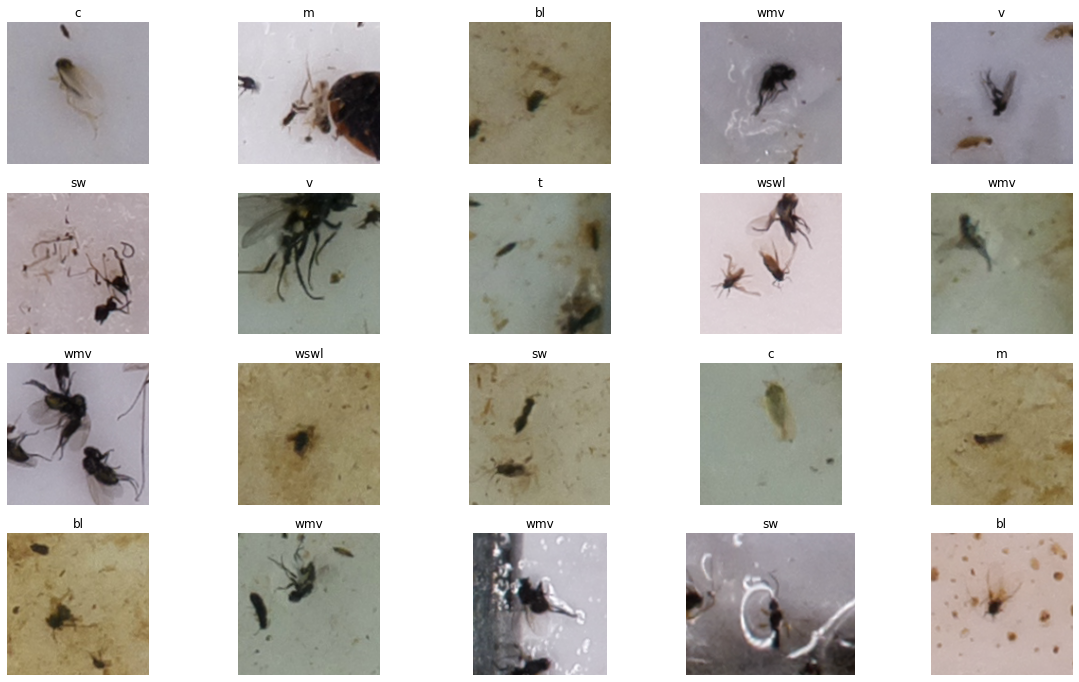

In [10]:
dfs.plot_samples(df[df.knn_outlier==1].sample(20))

In [11]:
df

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score
5071,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2021_UNDISTORTED_mollem_E_w24_4056x3040.png_bl...,UNDISTORTED_mollem_E_w24_4056x3040.png,2021,mollem,w24,e,3434,33.354577,4,142.500000,39.298990,240.486226,56.886324,187.441511,179.635156,188.336711,0,0.245593
3738,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2020_herent_w27_1-60_4056x3040_23062020144958....,herent_w27_1-60_4056x3040_23062020144958.jpg,2020,herent,w27,1-60,24440,28.877737,115,49.908696,16.366376,443.455794,79.262555,147.430993,146.961766,129.173245,0,0.370772
3737,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2021_UNDISTORTED_mollem_D_w26_4056x3040.png_bl...,UNDISTORTED_mollem_D_w26_4056x3040.png,2021,mollem,w26,d,3010,20.804309,2,99.000000,35.213203,99.000000,33.213203,214.879333,208.161644,214.512889,0,0.196021
3736,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2020_herent_w27_2-30_4056x3040_23062020145512....,herent_w27_2-30_4056x3040_23062020145512.jpg,2020,herent,w27,2-30,18533,22.507805,29,26.103448,13.925785,107.961869,27.472534,159.127363,152.304899,130.051664,0,0.524695
3735,/home/kalfasyan/data/images/sticky_plates/phot...,bl,2020_UNDISTORTED_herent_w30_2-30_4056x3040.png...,UNDISTORTED_herent_w30_2-30_4056x3040.png,2020,herent,w30,2-30,9622,33.061649,2,225.500000,86.012192,173.000000,48.455844,218.972311,209.376089,208.120933,0,0.212122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_brainelal_B_w36_4056x3040.png...,UNDISTORTED_brainelal_B_w36_4056x3040.png,2021,brainelalleud,w36,b,2049,17.944413,1,972.500000,270.551296,0.000000,0.000000,173.975022,157.309333,152.275556,0,0.316326
2464,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_landen_c_w40_4056x3040.png_ws...,UNDISTORTED_landen_c_w40_4056x3040.png,2021,landen,w40,c,379,33.199856,48,56.312500,19.335155,353.125312,78.533757,165.960716,147.974855,142.244385,0,0.531440
2465,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_landen_a_w40_4056x3040.png_ws...,UNDISTORTED_landen_a_w40_4056x3040.png,2021,landen,w40,a,5863,31.012843,6,82.000000,34.084944,166.074030,46.112395,189.213200,183.286756,187.373289,0,0.329615
2459,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_brainelal_c_w37_4056x3040.png...,UNDISTORTED_brainelal_c_w37_4056x3040.png,2021,brainelalleud,w37,c,3693,20.291821,1,635.500000,198.409161,0.000000,0.000000,166.773644,160.572578,168.380133,0,0.182653


In [12]:
print(f"Total of {df[df.knn_outlier==1].shape[0]} outliers found. (# of all datapoints: {df.shape[0]})")
df[df.knn_outlier==1].label.value_counts()

Total of 2667 outliers found. (# of all datapoints: 26655)


v       538
wmv     471
c       458
sw      245
t       238
bl      232
m       156
k       109
wrl     102
sp       61
wswl     57
Name: label, dtype: int64

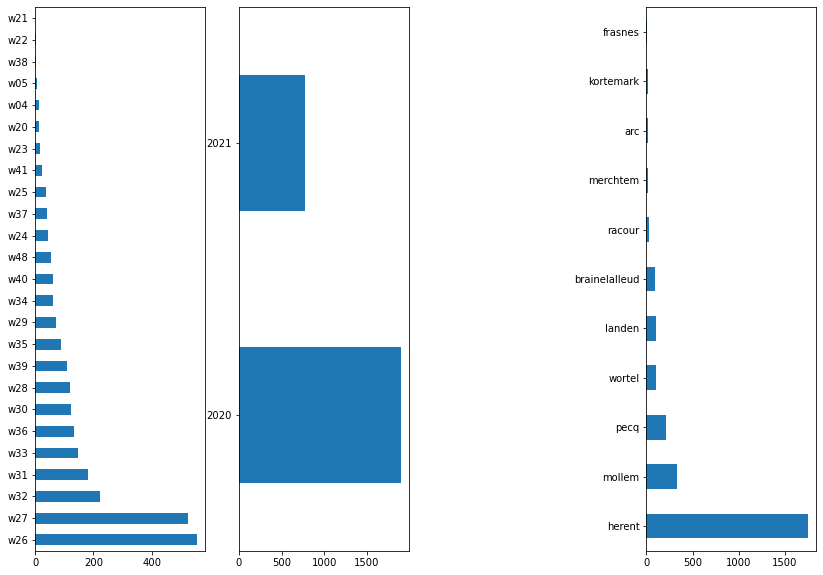

In [13]:
plt.figure(figsize=(24,12))
plt.subplot(1,4,1);
df[df.knn_outlier==1].date.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,2);
df[df.knn_outlier==1].year.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,4);
df[df.knn_outlier==1].location.value_counts().plot(kind='barh', figsize=(14,10));

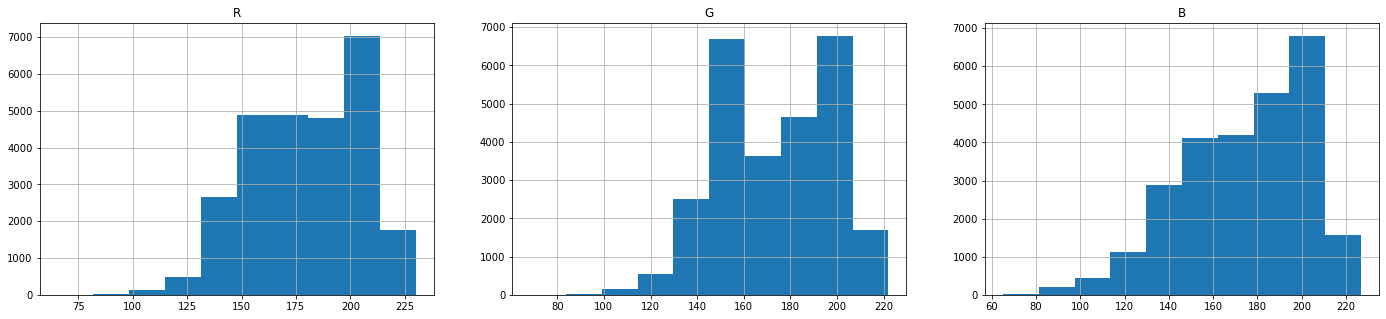

In [14]:
plt.figure(figsize=(24,5))
plt.subplot(1,3,1);
df.R.hist();plt.title('R')
plt.subplot(1,3,2);
df.G.hist();plt.title('G')
plt.subplot(1,3,3);
df.B.hist();plt.title('B');

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 52.40it/s]


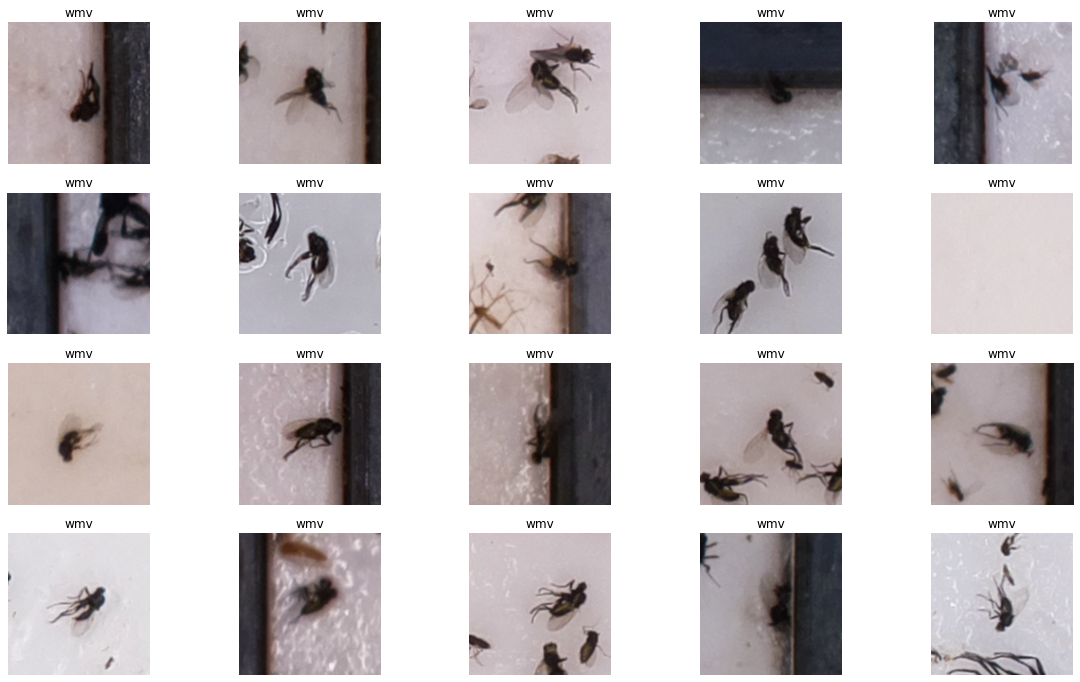

In [15]:
selection = 'label==\'wmv\' & knn_outlier==1 & nb_contours<15'
# selection = 'knn_outlier==1 & label==\'wmv\''
dfs.plot_samples(df.query(selection).sample(20))

In [16]:
df.query(selection).date.value_counts()

w36    14
w33     8
w39     8
w32     7
w34     5
w37     5
w40     5
w35     3
w30     3
w28     2
w31     1
w29     1
w27     1
w38     1
Name: date, dtype: int64

# CALCULAE IF INSECT IS CLOSER TO THE EDGE OF FOTO

In [17]:
# df[df.knn_outlier==0]

In [19]:
df.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')